In [1]:
import numpy as np
import pandas as pd
import os as os

In [2]:
os.chdir('/Users/raghuramkowdeed/Documents/afp/')

In [3]:
%pylab inline
exec(open("./run_model.py").read())
exec(open("./get_signal_names.py").read())
exec(open("./portfolio_optimizer.py").read())

import datetime
from pylab import rcParams


Populating the interactive namespace from numpy and matplotlib


In [4]:
use_rank = True

sig_dir = '/Users/raghuramkowdeed/Desktop/afp_data/rank/500/rps_data/'
fac_data_dir='/Users/raghuramkowdeed/Desktop/afp_data/rank/500/factor_exposure_data/'
fac_ret_file = '/Users/raghuramkowdeed/Desktop/afp_data/rank/500/fac_ret_file.csv'

if not use_rank:
    sig_dir = '/Users/raghuramkowdeed/Desktop/afp_data/norm/500/rps_data/'
    fac_data_dir='/Users/raghuramkowdeed/Desktop/afp_data/norm/500/factor_exposure_data/'
    fac_ret_file = '/Users/raghuramkowdeed/Desktop/afp_data/norm/500/fac_ret_file.csv'

In [5]:
sig_df = pd.DataFrame()
sig_files = os.listdir(sig_dir)
sig_files = np.sort(sig_files)

for sig_file in sig_files :
    if '.csv' not in sig_file :
        continue
    #print(sig_file)
    this_file = sig_dir + sig_file
    this_df = pd.read_csv(this_file, index_col = 'date')
    this_df.index = [ datetime.datetime.strptime(val, '%Y-%m-%d') for val in this_df.index]
    sig_df = sig_df.append(this_df)
data = sig_df.copy()

In [6]:
model_name = 'pls_regression'
train_model_arg = { 'n_components':50, 'scale':False, 'max_iter':5000, 'tol':1e-08, 'copy':True }
#model_name = 'linear_regression'
#train_model_arg = None


look_back = 12

In [7]:
begin_date = datetime.datetime.strptime('19900101', '%Y%m%d')
end_date = datetime.datetime.strptime('20170101', '%Y%m%d')

sig_df = sig_df[(sig_df.index>=begin_date) & (sig_df.index<end_date)]
sig_df = sig_df.fillna(sig_df.mean())

In [8]:
'res_ret' in sig_df.columns

True

In [9]:
#factor_names =  ['beta','mve', 'bm', 'roic', 'agr', 'mom12m', 'idiovol']
factor_names =  ['beta']
sig_names = get_signal_names()
ret_sr = sig_df['ret']
sig_df = sig_df[sig_names]
sig_df = sig_df.drop(factor_names, axis=1)

In [10]:
#dim_vec = range(5,90,10)
dim_vec = range(1,25,1)

In [11]:
model_sig_df = pd.DataFrame()

for this_dim in dim_vec :
    print(this_dim)
    train_model_arg['n_components'] = this_dim    
    model_sig_sr = run_model( sig_df, ret_sr, model_name, train_model_arg=train_model_arg, 
                          pred_model_arg ={},look_back=look_back)
    model_sig_df[this_dim] = model_sig_sr

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [12]:
'res_ret' in sig_df.columns

False

In [13]:

pm = PortfolioOptimizer(fac_data_dir=fac_data_dir,
                        fac_ret_file = fac_ret_file,
                        fac_cov_hl = 12.0,
                        fac_names = None
                       )



--------


In [14]:
#new_sig_df = pd.DataFrame()

#for sig_name in sig_df.columns :
#    this_sig = sig_df[sig_name]
#    this_sig = pm.neu_signal(this_sig)
#    this_sig = this_sig.fillna(this_sig.mean())
#    new_sig_df[sig_name] = this_sig
#sig_df = new_sig_df

In [15]:
pnl_df = pd.DataFrame()
for i in range( model_sig_df.shape[1]):
    print(i)
    pnl_sr = pm.run_signal(sig_sr=model_sig_df.iloc[:,i],neu_sig=True)
    pnl_df[dim_vec[i]] = pnl_sr

pnl_df[0] = np.zeros(pnl_df.shape[0])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


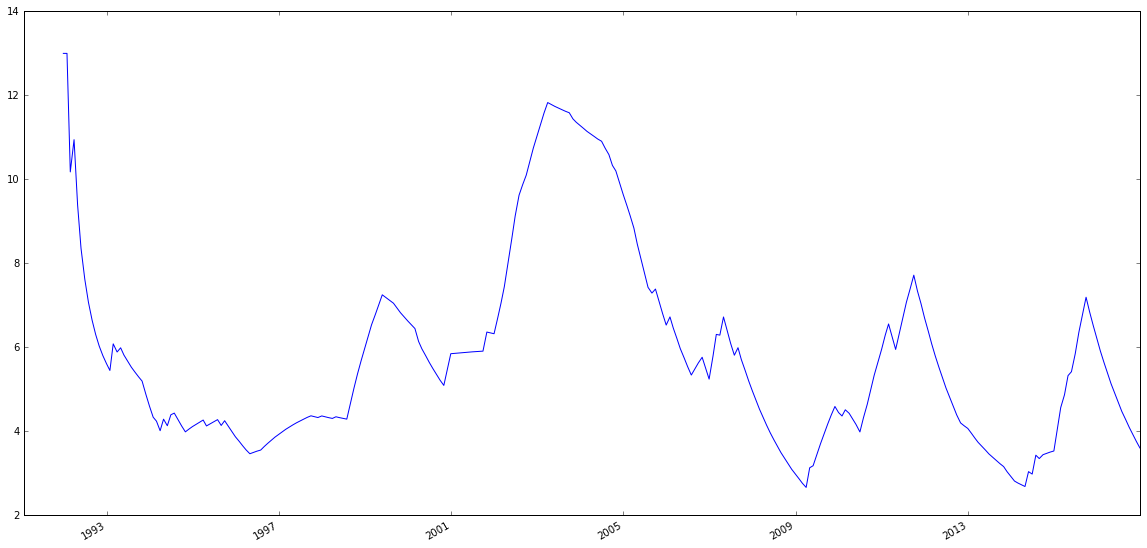

In [51]:
window = 12
pnl_df_avg = ( pnl_df.rolling(window=window).mean()*sqrt(12) ) /( pnl_df.rolling(window=window).std() )
#pnl_df_avg = ( pnl_df.rolling(window=window).mean()*sqrt(12) )    
max_ind = pnl_df_avg.idxmax(axis=1)
min_ind = pnl_df_avg.idxmin(axis=1)
max_ind_smt = max_ind.ewm(halflife=window).mean()

rcParams['figure.figsize'] = 20,10
max_ind_smt.plot()

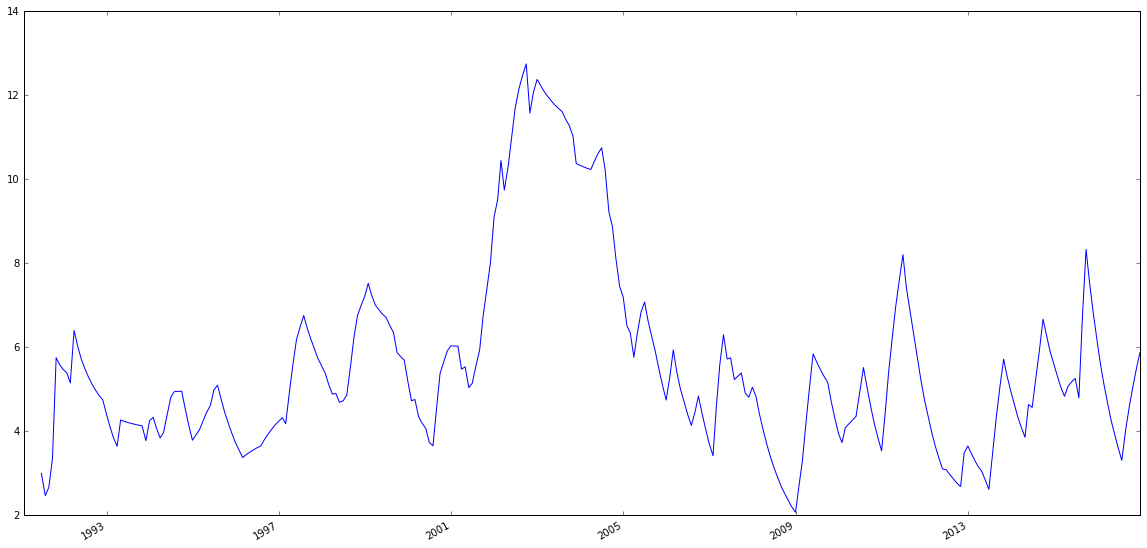

In [52]:
window = 6
pnl_df_avg = ( pnl_df.rolling(window=window).mean()*sqrt(12) ) /( pnl_df.rolling(window=window).std() )
#pnl_df_avg = ( pnl_df.rolling(window=window).mean()*sqrt(12) )    
max_ind = pnl_df_avg.idxmax(axis=1)
min_ind = pnl_df_avg.idxmin(axis=1)
max_ind_smt = max_ind.ewm(halflife=window).mean()

rcParams['figure.figsize'] = 20,10
max_ind_smt.plot()

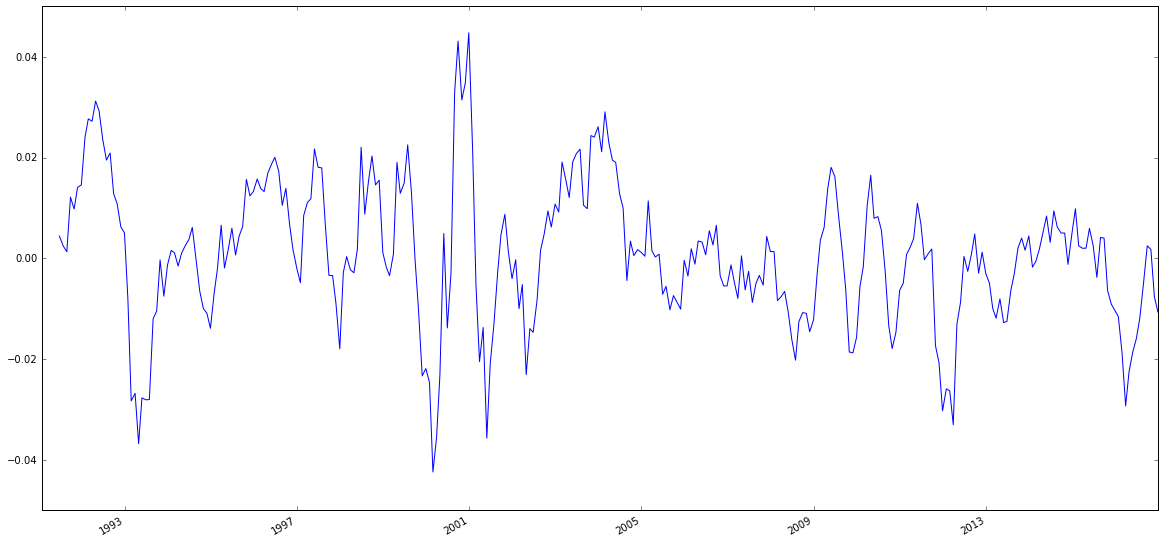

In [18]:
(pnl_df_avg.iloc[:,-2] - pnl_df_avg.iloc[:,0] ).plot()

In [19]:
pnl_df.mean(axis=0)*sqrt(12)/pnl_df.std(axis=0)

1     0.688659
2     0.786754
3     0.852090
4     0.872652
5     0.918085
6     0.920227
7     0.909433
8     0.917932
9     0.927174
10    0.929162
11    0.931255
12    0.917940
13    0.926127
14    0.927902
15    0.924439
16    0.921466
17    0.918290
18    0.916851
19    0.915256
20    0.914988
21    0.914861
22    0.912586
23    0.912619
24    0.914692
0          NaN
dtype: float64

In [20]:
dim_sr = pd.Series( dim_vec, index = pnl_df_avg.columns[:-1] )

In [21]:
c = ( pnl_df.iloc[:,:-1] ).corrwith(dim_sr, axis=1) 

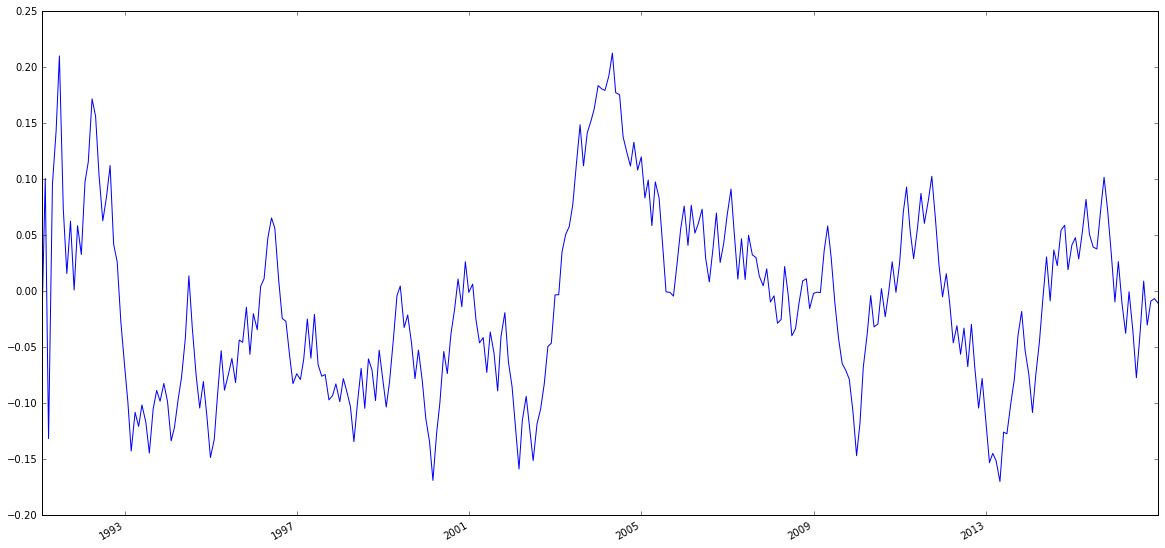

In [27]:
c.ewm(halflife=12).mean().plot()

In [79]:
import statsmodels.api as sm
lm_weights = []
lm_tstats = []
lm_pvalues = []

window = 24
pnl_df_avg = pnl_df.ewm(halflife=window).mean()*sqrt(12)/pnl_df.ewm(halflife=window).std()
#pnl_df_avg.dropna(inplace=True, axis=1)

for i in range(window,pnl_df_avg.shape[0]):
    lm = LinearRegression(fit_intercept=True)
    X = pd.DataFrame()
    X['x'] = dim_sr.iloc[0:5]
    y = pnl_df_avg.iloc[i,0:5]
    #y = ( y - y.mean())/y.std()
    X = sm.add_constant(X, prepend=False)
    model = sm.OLS(y,X)
    results = model.fit()
    lm_weights.append( results.params[0] )

    lm_tstats.append( results.tvalues[0] )
    lm_pvalues.append(results.f_pvalue)

    
dates = pnl_df.index[:-window]
print(dates.shape)
print(pnl_df_avg.shape)

lm_weights = pd.Series(lm_weights, index = dates)
lm_tstats = pd.Series(lm_tstats, index = dates)
lm_pvalues = pd.Series(lm_pvalues, index = dates)

(288,)
(312, 25)


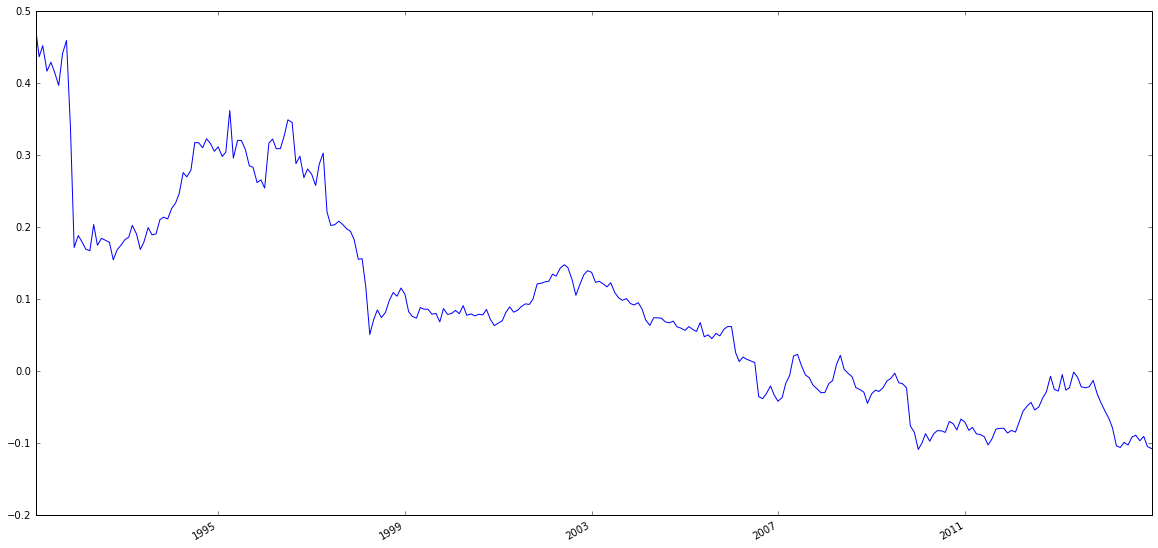

In [80]:
#lm_weights.ewm(halflife=1).mean().plot()
lm_weights.plot()

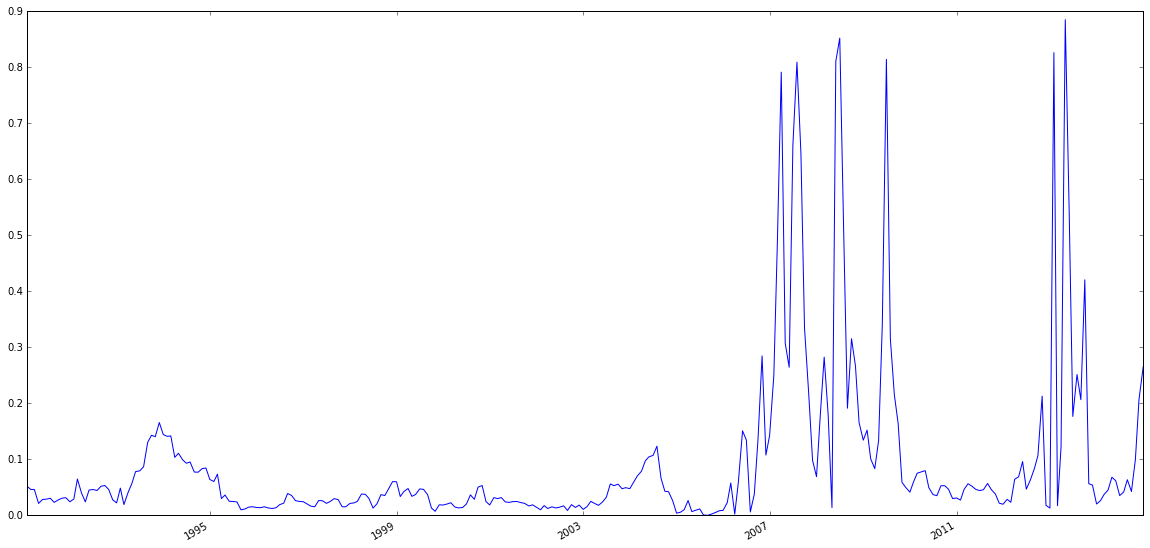

In [81]:
lm_pvalues.plot()

In [82]:
lm_pvalues

1991-01-31    0.051703
1991-02-28    0.046336
1991-03-28    0.046251
1991-04-30    0.021373
1991-05-31    0.028459
1991-06-28    0.028878
1991-07-31    0.030614
1991-08-30    0.023273
1991-09-30    0.027508
1991-10-31    0.030724
1991-11-29    0.031654
1991-12-31    0.024318
1992-01-31    0.029212
1992-02-28    0.064914
1992-03-31    0.040052
1992-04-30    0.024150
1992-05-29    0.045251
1992-06-30    0.046153
1992-07-31    0.044509
1992-08-31    0.052018
1992-09-30    0.053318
1992-10-30    0.046288
1992-11-30    0.027934
1992-12-31    0.022365
1993-01-29    0.048622
1993-02-26    0.019336
1993-03-31    0.041194
1993-04-30    0.057360
1993-05-28    0.078102
1993-06-30    0.079561
                ...   
2012-07-31    0.063329
2012-08-31    0.083425
2012-09-28    0.106752
2012-10-31    0.212916
2012-11-30    0.017970
2012-12-31    0.013096
2013-01-31    0.826341
2013-02-28    0.017303
2013-03-28    0.122208
2013-04-30    0.885238
2013-05-31    0.538523
2013-06-28    0.176723
2013-07-31 

In [71]:
pnl_df_avg

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,0
1991-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-02-28,-1.759615,3.197376,9.896318,3.778930,5.308692,3.297134,2.555464,3.725033,3.525685,3.958672,...,5.509650,6.314223,6.623954,6.992676,7.668407,7.947170,7.576718,7.028381,6.855315,NaN
1991-03-28,0.378848,4.862984,5.027111,2.940184,5.166198,3.484972,2.361528,2.266407,2.958039,2.537298,...,3.579825,3.318428,3.660430,3.830679,4.094973,4.064165,4.168944,4.037153,3.896370,NaN
1991-04-30,-1.361924,-0.195686,-0.001019,-0.510294,-0.604686,-0.637782,-0.845826,-0.959067,-0.970851,-0.914070,...,-0.760193,-0.745410,-0.699085,-0.668948,-0.670966,-0.669866,-0.674644,-0.697903,-0.696058,NaN
1991-05-31,-1.770606,-1.061519,-0.803453,-1.265555,-1.490975,-1.508547,-1.699044,-1.790550,-1.765068,-1.683537,...,-1.535685,-1.533462,-1.505617,-1.466752,-1.480901,-1.476759,-1.474798,-1.498287,-1.492475,NaN
1991-06-28,-1.696006,-1.411562,-0.946537,-1.314248,-1.243989,-1.275038,-1.240622,-1.481588,-1.309314,-1.206991,...,-1.267593,-1.260584,-1.211882,-1.177987,-1.196423,-1.183228,-1.190550,-1.208716,-1.204454,NaN
1991-07-31,-1.238915,-0.769765,-0.411055,-0.550054,-0.580488,-0.610160,-0.812801,-1.171650,-1.045551,-0.921883,...,-0.882877,-0.882626,-0.868430,-0.838813,-0.836815,-0.814540,-0.818068,-0.833669,-0.841931,NaN
1991-08-30,-0.813422,0.138722,0.458003,0.265127,0.210682,0.114708,-0.109792,-0.403710,-0.327632,-0.157550,...,-0.053261,-0.048839,-0.044174,-0.029716,-0.029306,-0.020138,-0.027389,-0.030264,-0.033166,NaN
1991-09-30,-0.863924,0.633564,0.853497,0.795778,0.872573,0.831380,0.718125,0.418609,0.510946,0.584849,...,0.684747,0.702815,0.710819,0.711886,0.716878,0.727756,0.720244,0.718154,0.715709,NaN
1991-10-31,-0.400268,0.931528,1.126464,1.009559,1.140608,1.069145,0.960268,0.702319,0.781322,0.774324,...,0.943527,0.956251,0.967678,0.963348,0.966182,0.977918,0.974546,0.971033,0.967527,NaN


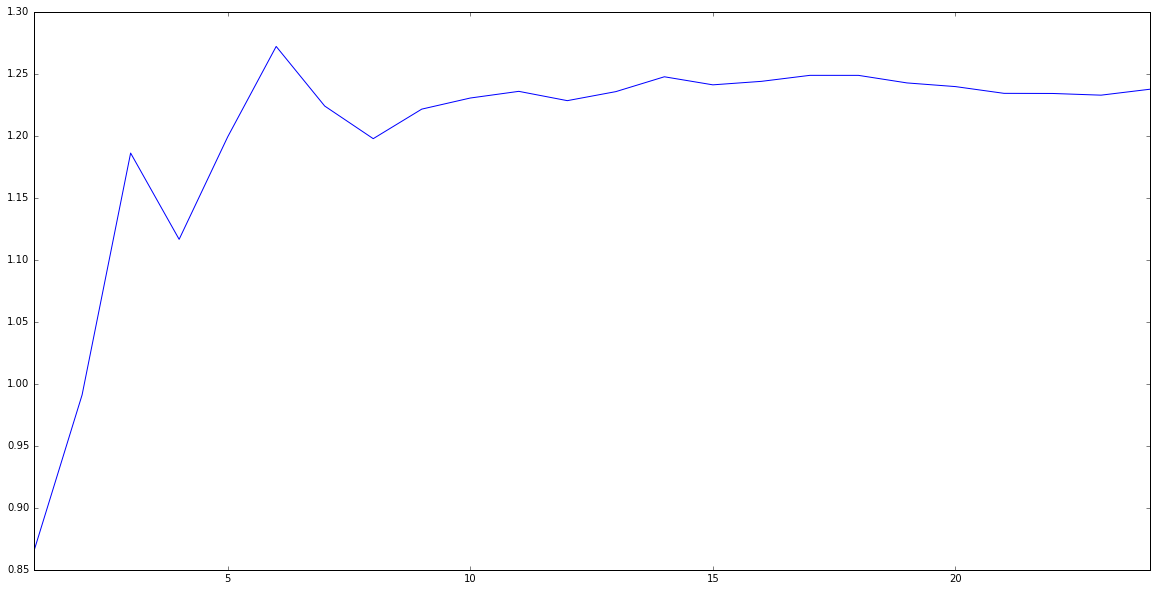

In [85]:
pnl_df_avg.loc[datetime.datetime.strptime('20010731', '%Y%m%d')].iloc[:-1].plot()

In [70]:
pnl_df.columns

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24,  0],
           dtype='int64')